In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
from matplotlib import colormaps  



In [2]:
# LOAD INTERMEDIATE DATA

# # # User input: session folder
session_folder = "/root/capsule/scratch/session_analysis_in_distribution/behavior_716325_2024-05-31_10-31-14"

# Build paths
intermediate_dir = Path(session_folder) / "intermediate_data"
movements_path = intermediate_dir / "tongue_movs.parquet"
df_trials_path = intermediate_dir / "nwb_df_trials.parquet"
df_licks_path = intermediate_dir / "nwb_df_licks.parquet"

# Load dataframes
tongue_movements = pd.read_parquet(movements_path)
df_trials = pd.read_parquet(df_trials_path)
df_licks = pd.read_parquet(df_licks_path)


print(tongue_movements.columns)

Index(['movement_id', 'start_time', 'end_time', 'duration', 'min_x', 'max_x',
       'min_y', 'max_y', 'min_xv', 'max_xv', 'min_yv', 'max_yv',
       'peak_velocity', 'mean_velocity', 'total_distance', 'startpoint_x',
       'startpoint_y', 'endpoint_x', 'endpoint_y', 'time_to_endpoint',
       'excursion_angle_deg', 'max_x_from_jaw', 'max_x_from_jaw_y',
       'max_y_from_jaw', 'max_y_from_jaw_x', 'max_x_distance',
       'max_y_distance', 'n_datapoints', 'dropped_frames_n',
       'dropped_frames_pct', 'has_lick', 'first_lick_index', 'lick_count',
       'trial', 'cue_response', 'rewarded', 'event'],
      dtype='object')


In [3]:
# example: time of first tongue movement on each trial:
df = tongue_movements.copy()

# Get first start_time per trial
first_start_times = df.groupby('trial', as_index=False).nth(0)[['trial', 'start_time']]

print(first_start_times)


      trial   start_time
20      0.0     0.190304
48      1.0    13.650272
88      2.0    29.780192
142     3.0    63.880128
220     4.0   136.206016
...     ...          ...
7232  581.0  5291.530560
7236  582.0  5297.304576
7238  583.0  5307.098528
7240  584.0  5314.612512
7243  585.0  5321.664512

[568 rows x 2 columns]


In [4]:
# example: whether first tongue movement is a lick (would be a cue response lick)
# Group by trial and get the first movement row for each trial
df = tongue_movements.copy()

first_movements = df.groupby('trial').nth(0).reset_index()

# Select only the trial, has_lick, and cue_response columns
first_movement_licks = first_movements[['trial', 'has_lick', 'cue_response']]
print(first_movement_licks)
#NB: cue_response == None means there was no lick detected by lickometer.

# # Sanity check: Find rows where has_lick is False and cue_response is True (should never happen)
# violation_rows = first_movement_licks[(first_movement_licks['has_lick'] == False) & (first_movement_licks['cue_response'] == True)]
# print(violation_rows)


     trial  has_lick cue_response
0      0.0     False         None
1      1.0      True         True
2      2.0     False         None
3      3.0     False         None
4      4.0     False         None
..     ...       ...          ...
563  581.0      True         True
564  582.0      True         True
565  583.0      True         True
566  584.0      True         True
567  585.0      True         True

[568 rows x 3 columns]


In [5]:
# example analysis

from aind_dynamic_foraging_behavior_video_analysis.kinematics.tongue_kinematics_utils import aggregate_tongue_movements, add_lick_metadata_to_movements

def annotate_movement_timing(tongue_movements: pd.DataFrame,
                             df_trials: pd.DataFrame) -> pd.DataFrame:
    """
    Annotate each movement with trial-relative metrics and
    invalidate any movement that spans a go-cue boundary.

    New columns (nullable):
      • movement_number_in_trial       Int64  
      • cue_response_movement_number   Int64  
      • movement_before_cue_response   boolean  
      • movement_latency_from_go       Float64  
      • lick_latency                   Float64 (lick_time - go cue time)

    Pre-trial or spanning movements keep all-new as NA.
    """

    # --- Sanity checks ---
    required_cols = {'trial', 'start_time', 'end_time', 'cue_response', 'lick_time'}
    missing = required_cols - set(tongue_movements.columns)
    if missing:
        raise ValueError(f"Missing columns in tongue_movements: {missing}")
    if not {'trial', 'goCue_start_time_in_session'}.issubset(df_trials):
        raise ValueError("df_trials must contain 'trial' and 'goCue_start_time_in_session'")

    df = tongue_movements.copy()

    # --- Null-out any movement spanning a go-cue ---
    go_times = df_trials['goCue_start_time_in_session']
    uniq = df[['movement_id', 'start_time', 'end_time']].drop_duplicates()
    bad_ids = {
        m for m, s, e in uniq.itertuples(index=False)
        if ((go_times > s) & (go_times < e)).any()
    }
    df.loc[df['movement_id'].isin(bad_ids), 'trial'] = pd.NA

    # --- Map go-cue times onto each movement row ---
    go_map = df_trials.set_index('trial')['goCue_start_time_in_session']
    df['goCue_start_time_in_session'] = df['trial'].map(go_map)

    # --- Validate ordering by (trial, start_time) ---
    valid_trials = df['trial'].dropna()
    if not valid_trials.is_monotonic_increasing:
        raise ValueError("Trials not in ascending order")
    within_trial_sorted = (
        df.dropna(subset=['trial'])
          .groupby('trial', sort=False)['start_time']
          .apply(lambda x: x.dropna().is_monotonic_increasing)
          .all()
    )
    if not within_trial_sorted:
        raise ValueError("start_time not monotonic within trial")

    # --- Annotate movement timing ---
    df['movement_number_in_trial'] = df.groupby('trial').cumcount() + 1
    df['cue_response_movement_number'] = (
        df.groupby('trial')['movement_number_in_trial']
          .transform(lambda m: m.where(df.loc[m.index, 'cue_response']).max())
    )
    df['movement_before_cue_response'] = (
        df['movement_number_in_trial'] < df['cue_response_movement_number']
    )
    df['movement_latency_from_go'] = (
        df['start_time'] - df['goCue_start_time_in_session']
    ).where(df['start_time'] >= df['goCue_start_time_in_session'])

    # --- Compute lick latency (lick_time - go cue time, only for cue_response trials) ---
    lick_latency_map = (
        df.loc[df['cue_response'] == True]
          .set_index('trial')
          .eval('lick_time - goCue_start_time_in_session')
          .rename('lick_latency')
    )
    df['lick_latency'] = df['trial'].map(lick_latency_map)

    # --- Cast to nullable dtypes ---
    df = df.astype({
        'movement_number_in_trial':       'Int64',
        'cue_response_movement_number':   'Int64',
        'movement_before_cue_response':   'boolean',
        'movement_latency_from_go':       'Float64',
        'lick_latency':                   'Float64'
    })

    # --- Blank out all new annotations for pre-trial or invalid rows ---
    is_pre = df['trial'].isna()
    df.loc[is_pre, [
        'movement_number_in_trial',
        'cue_response_movement_number',
        'movement_before_cue_response',
        'movement_latency_from_go',
        'lick_latency'
    ]] = pd.NA

    return df


# Add lick time from licks_df
tongue_movements = add_lick_metadata_to_movements(
    tongue_movements,
    df_licks,
    fields=['timestamps']
)
tongue_movements = tongue_movements.rename(columns={'timestamps': 'lick_time'})

# Annotate movements using trials
tongue_movements = annotate_movement_timing(tongue_movements, df_trials)


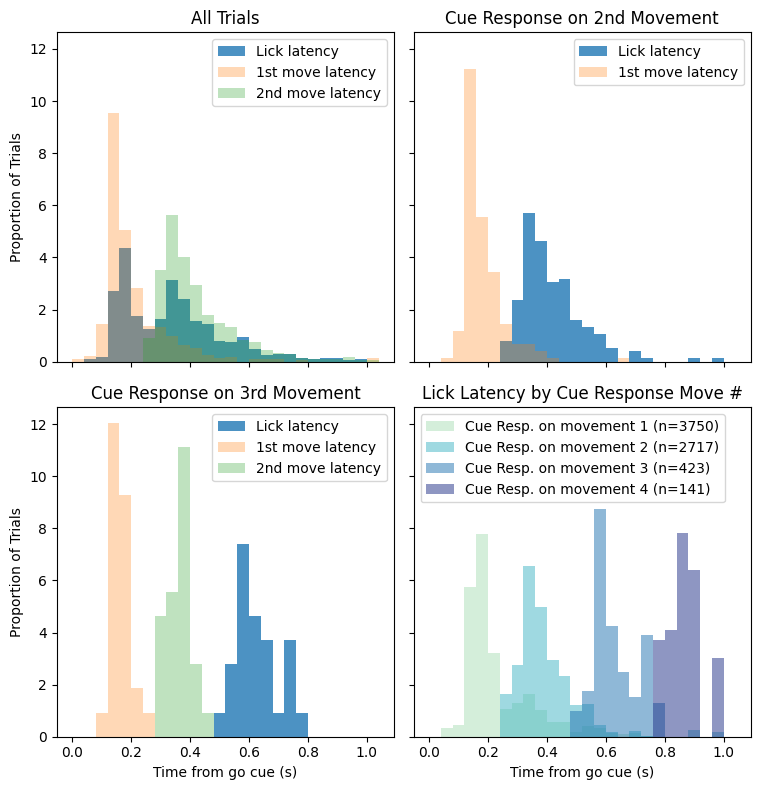

In [6]:
# plotting results: latency of cue response tongue movements, sorted by movement ordinal

# --- Shared settings ---
bins = np.arange(0, 1.05, 0.04)
colors = {
    "lick": "#1f77b4",
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.ravel()

# -------------------------------
# Subplot 1: All trials
# -------------------------------
df = tongue_movements.copy()

lick_lat = df.drop_duplicates('trial')['lick_latency'].dropna()

moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[0]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="All Trials", ylabel="Proportion of Trials")
ax.legend()

# -------------------------------
# Subplot 2: Cue response on 2nd movement
# -------------------------------
trials_2nd = df.loc[df['cue_response_movement_number'] == 2, 'trial'].unique()
df_2nd = df.query("trial in @trials_2nd and movement_number_in_trial <= 2")

lick_lat = df_2nd['lick_latency']

moves = (
    df_2nd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']

ax = axes[1]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.set(title="Cue Response on 2nd Movement")
ax.legend()

# -------------------------------
# Subplot 3: Cue response on 3rd movement
# -------------------------------
trials_3rd = df.loc[df['cue_response_movement_number'] == 3, 'trial'].unique()
df_3rd = df.query("trial in @trials_3rd and movement_number_in_trial <= 3")

lick_lat = df_3rd['lick_latency']

moves = (
    df_3rd[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)
first_move = moves.groupby('trial').nth(0)['movement_latency_from_go']
second_move = moves.groupby('trial').nth(1)['movement_latency_from_go'].dropna()

ax = axes[2]
ax.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
ax.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
ax.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
ax.set(title="Cue Response on 3rd Movement", xlabel="Time from go cue (s)", ylabel="Proportion of Trials")
ax.legend()

# -------------------------------
# Subplot 4: Lick latency by cue_response_movement_number (1-4)
# -------------------------------
lick_latencies_by_cue = (
    df.dropna(subset=['lick_latency'])
      .query("cue_response_movement_number <= 4")
      .groupby('cue_response_movement_number')['lick_latency']
      .apply(list)
      .to_dict()
)

cmap = plt.colormaps['YlGnBu']
colors = cmap(np.linspace(0.3, 0.9, 4))

ax = axes[3]
for n in sorted(lick_latencies_by_cue.keys()):
    latencies = lick_latencies_by_cue[n]
    ax.hist(
        latencies, bins=bins, density=True, alpha=0.5,
        label=f"Cue Resp. on movement {n} (n={len(latencies)})",
        color=colors[n-1]
    )
ax.set(title="Lick Latency by Cue Response Move #", xlabel="Time from go cue (s)")
ax.legend(loc="upper left")

# --- Final layout ---
fig.tight_layout()
plt.show()





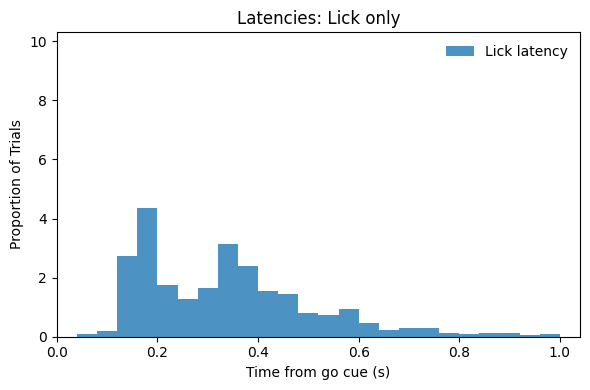

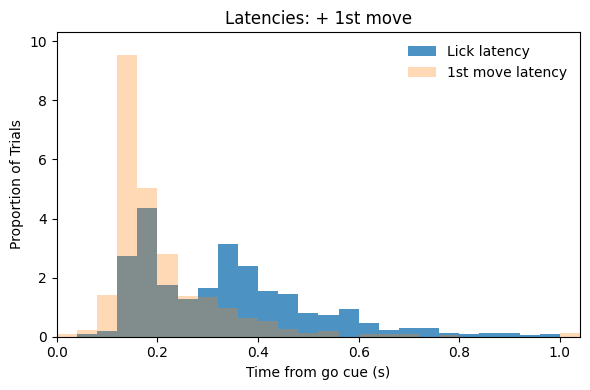

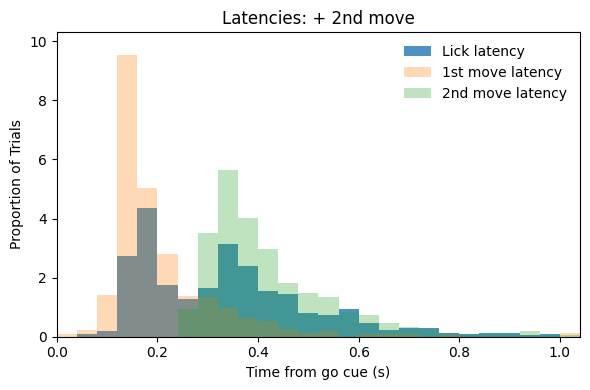

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Settings (match your palette) ---
bins = np.arange(0, 1.05, 0.04)
colors = {
    "lick": "#1f77b4",
    "first": "#ff7f0e",
    "second": "#2ca02c",
}
alpha_lick = 0.8
alpha_move = 0.3
figsize = (6, 4)   # adjust as needed
xlabel = "Time from go cue (s)"
ylabel = "Proportion of Trials"
title_prefix = "Latencies"

# --- Extract latencies ---
df = tongue_movements.copy()

# Lick latency (one per trial)
lick_lat = (
    df.drop_duplicates('trial')['lick_latency']
      .dropna()
)

# Movement latencies ordered within each trial
moves = (
    df[['trial', 'movement_number_in_trial', 'movement_latency_from_go']]
    .dropna(subset=['movement_latency_from_go'])
    .sort_values(['trial', 'movement_number_in_trial'])
)

first_move = (
    moves.groupby('trial')
         .nth(0)['movement_latency_from_go']
         .dropna()
)
second_move = (
    moves.groupby('trial')
         .nth(1)['movement_latency_from_go']
         .dropna()
)

# --- Compute shared axis limits ---
# Use density=True like the plots; take the max bin height across all three
def max_density(arr):
    if len(arr) == 0:
        return 0.0
    hist, _ = np.histogram(arr, bins=bins, density=True)
    return hist.max() if len(hist) else 0.0

ymax = max(
    max_density(lick_lat),
    max_density(first_move),
    max_density(second_move),
)
# Add a small headroom so the tallest bar doesn't touch the top
ymax = ymax * 1.08 if ymax > 0 else 1.0

xlim = (bins[0], bins[-1])
ylim = (0, ymax)

# --- Panel A: Lick latency only ---
figA, axA = plt.subplots(figsize=figsize)
axA.hist(lick_lat, bins=bins, density=True, alpha=alpha_lick, color=colors["lick"], label="Lick latency")
axA.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: Lick only")
axA.legend(frameon=False)
figA.tight_layout()
# figA.savefig("panelA_lick_only.png", dpi=300, bbox_inches="tight")  # uncomment to save

# --- Panel B: + 1st move latency (superimposed) ---
figB, axB = plt.subplots(figsize=figsize)
axB.hist(lick_lat,   bins=bins, density=True, alpha=alpha_lick, color=colors["lick"],  label="Lick latency")
axB.hist(first_move, bins=bins, density=True, alpha=alpha_move, color=colors["first"], label="1st move latency")
axB.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: + 1st move")
axB.legend(frameon=False)
figB.tight_layout()
# figB.savefig("panelB_lick_plus_first.png", dpi=300, bbox_inches="tight")  # uncomment to save

# --- Panel C: + 2nd move latency (superimposed) ---
figC, axC = plt.subplots(figsize=figsize)
axC.hist(lick_lat,    bins=bins, density=True, alpha=alpha_lick, color=colors["lick"],   label="Lick latency")
axC.hist(first_move,  bins=bins, density=True, alpha=alpha_move, color=colors["first"],  label="1st move latency")
axC.hist(second_move, bins=bins, density=True, alpha=alpha_move, color=colors["second"], label="2nd move latency")
axC.set(xlim=xlim, ylim=ylim, xlabel=xlabel, ylabel=ylabel, title=f"{title_prefix}: + 2nd move")
axC.legend(frameon=False)
figC.tight_layout()
# figC.savefig("panelC_lick_plus_first_second.png", dpi=300, bbox_inches="tight")  # uncomment to save


In [7]:
def augment_trials_with_movement_summary(tongue_movements_annotated: pd.DataFrame,
                                         df_trials: pd.DataFrame) -> pd.DataFrame:
    """
    Adds trial-level columns to df_trials:
      • has_prelick_movement (boolean): any movement occurred before the cue-response movement
      • first_movement_latency_from_go (Float64): latency of the first movement from go cue
      • cue_response_movement_number (Int64): which movement number was the cue-response lick on
    """
    required = {
        'trial',
        'movement_number_in_trial',
        'cue_response_movement_number',
        'movement_before_cue_response',
        'movement_latency_from_go',
        'cue_response'
    }
    missing = required - set(tongue_movements_annotated.columns)
    if missing:
        raise ValueError(f"tongue_movements_annotated missing columns: {missing}")

    mv = tongue_movements_annotated.dropna(subset=['trial']).copy()

    # 1) Did any movement occur before the cue-response movement?
    prelick_by_trial = (
        mv.groupby('trial', sort=False)['movement_before_cue_response']
          .any()                  # True if any pre-lick movement in that trial
    )

    # 2) First movement latency from go (take the minimum non-null latency)
    first_latency_by_trial = (
        mv.groupby('trial', sort=False)['movement_latency_from_go']
          .min()                  # first movement after go has the smallest latency
    )

    # 3) Which movement number was the cue-response lick on?
    cue_move_num_by_trial = (
        mv.loc[mv['cue_response'] == True]
          .groupby('trial', sort=False)['movement_number_in_trial']
          .min()                  # there should be one per trial; min/first are equivalent
    )

    # Map onto trials
    trials_out = df_trials.copy()
    trials_out['has_prelick_movement'] = trials_out['trial'].map(prelick_by_trial)
    trials_out['first_movement_latency_from_go'] = trials_out['trial'].map(first_latency_by_trial)
    trials_out['cue_response_movement_number'] = trials_out['trial'].map(cue_move_num_by_trial)

    # Cast to nullable dtypes
    trials_out = trials_out.astype({
        'has_prelick_movement': 'boolean',
        'first_movement_latency_from_go': 'Float64',
        'cue_response_movement_number': 'Int64'
    })

    # Optional: if you prefer no NAs in the boolean, assume False when no movements are present
    trials_out['has_prelick_movement'] = trials_out['has_prelick_movement'].fillna(False)

    return trials_out


In [8]:
# Add movement summary to trials dataframe
df_trials = augment_trials_with_movement_summary(tongue_movements, df_trials)


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def _confidence_ellipse(x, y, ax, n_std=1.0, **kwargs):
    """
    Draw a covariance ellipse of x and y at n_std standard deviations.
    """
    x = np.asarray(x); y = np.asarray(y)
    if x.size < 2 or y.size < 2:
        return None
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    mean_x, mean_y = np.mean(x), np.mean(y)
    ell = Ellipse((mean_x, mean_y), width, height, angle=theta, **kwargs)
    ax.add_patch(ell)
    return ell

def plot_endpoints_until_cue_response(
    tongue_movements: pd.DataFrame,
    normalize_to_cue: bool = True,
    max_movement_to_show=None,
    line_alpha: float = 0.15,
    point_alpha: float = 0.5,
    point_size: float = 12,
    ellipse_alpha: float = 0.18,
    n_std_ellipse: float = 1.0,
    figsize=(7.5, 7.5),
):
    """
    Plot endpoint_x/endpoint_y for each movement up to the cue-response movement,
    colored by movement_number_in_trial. Optionally normalize so the cue-response
    endpoint is (0,0) per trial.

    Requires columns:
      ['trial', 'movement_number_in_trial', 'cue_response_movement_number',
       'endpoint_x', 'endpoint_y']
    """

    req = {'trial', 'movement_number_in_trial', 'cue_response_movement_number',
           'endpoint_x', 'endpoint_y'}
    missing = req - set(tongue_movements.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = tongue_movements.copy()

    # Keep only valid rows with numeric endpoints and movement numbers
    df = df.dropna(subset=['trial', 'movement_number_in_trial',
                           'cue_response_movement_number', 'endpoint_x', 'endpoint_y'])

    # Only movements up to and including the cue-response movement
    df = df[df['movement_number_in_trial'] <= df['cue_response_movement_number']]

    # (Optional) cap how many early movements to visualize (e.g., <= 5)
    if max_movement_to_show is not None:
        df = df[df['movement_number_in_trial'] <= max_movement_to_show]

    # Build per-trial reference = cue-response endpoint (the “target” the tongue finally hit)
    if normalize_to_cue:
        cue_endpoints = (
            df.loc[df['movement_number_in_trial'] == df['cue_response_movement_number'],
                   ['trial', 'endpoint_x', 'endpoint_y']]
              .drop_duplicates('trial')
              .set_index('trial')
              .rename(columns={'endpoint_x': 'cue_x', 'endpoint_y': 'cue_y'})
        )
        df = df.join(cue_endpoints, on='trial', how='inner')
        df['x_rel'] = df['endpoint_x'] - df['cue_x']
        df['y_rel'] = df['endpoint_y'] - df['cue_y']
        x_col, y_col = 'x_rel', 'y_rel'
        axis_label = 'Endpoint (relative to cue-response endpoint)'
    else:
        x_col, y_col = 'endpoint_x', 'endpoint_y'
        axis_label = 'Endpoint (absolute)'

    # Prepare colors for discrete movement numbers
    mov_nums = np.sort(df['movement_number_in_trial'].unique())
    # Use tab10 repeatedly if >10
    cmap = plt.get_cmap('tab10')
    color_map = {m: cmap((m-1) % 10) for m in mov_nums}

    fig, ax = plt.subplots(figsize=figsize)

    # Thin lines per trial showing progression of endpoints before the successful lick
    for trial, g in df.sort_values(['trial', 'movement_number_in_trial']).groupby('trial'):
        ax.plot(g[x_col], g[y_col], '-', alpha=line_alpha, linewidth=0.8, zorder=1)

    # Scatter points colored by movement number
    for m, g in df.groupby('movement_number_in_trial'):
        ax.scatter(
            g[x_col], g[y_col],
            s=point_size, alpha=point_alpha, label=f'Movement {m}',
            color=color_map[m], edgecolor='none', zorder=2
        )

    # Centroids + 1 SD ellipse for each movement ordinal
    for m, g in df.groupby('movement_number_in_trial'):
        # centroid
        cx, cy = g[x_col].mean(), g[y_col].mean()
        ax.scatter([cx], [cy], s=60, marker='X', color=color_map[m], zorder=3)
        # ellipse
        _confidence_ellipse(
            g[x_col], g[y_col], ax, n_std=n_std_ellipse,
            facecolor=color_map[m], edgecolor='none', alpha=ellipse_alpha, zorder=2
        )

    # Zero reference if normalized
    if normalize_to_cue:
        ax.axhline(0, linewidth=0.6, alpha=0.3)
        ax.axvline(0, linewidth=0.6, alpha=0.3)

    ax.set_aspect('equal')
    ax.set_xlabel(f'{axis_label}: X')
    ax.set_ylabel(f'{axis_label}: Y')
    title_bits = []
    title_bits.append("Tongue movement endpoints up to cue-response")
    if normalize_to_cue:
        title_bits.append(" (re-centered so cue-response endpoint = (0,0))")
    ax.set_title(''.join(title_bits))
    ax.legend(title='Movement number', frameon=False, ncol=min(4, len(mov_nums)))
    plt.tight_layout()
    return fig, ax


/tmp/ipykernel_42314/3795118371.py:18: RuntimeWarning: invalid value encountered in sqrt
  width, height = 2 * n_std * np.sqrt(vals)


(<Figure size 750x750 with 1 Axes>,
 <Axes: title={'center': 'Tongue movement endpoints up to cue-response'}, xlabel='Endpoint (absolute): X', ylabel='Endpoint (absolute): Y'>)

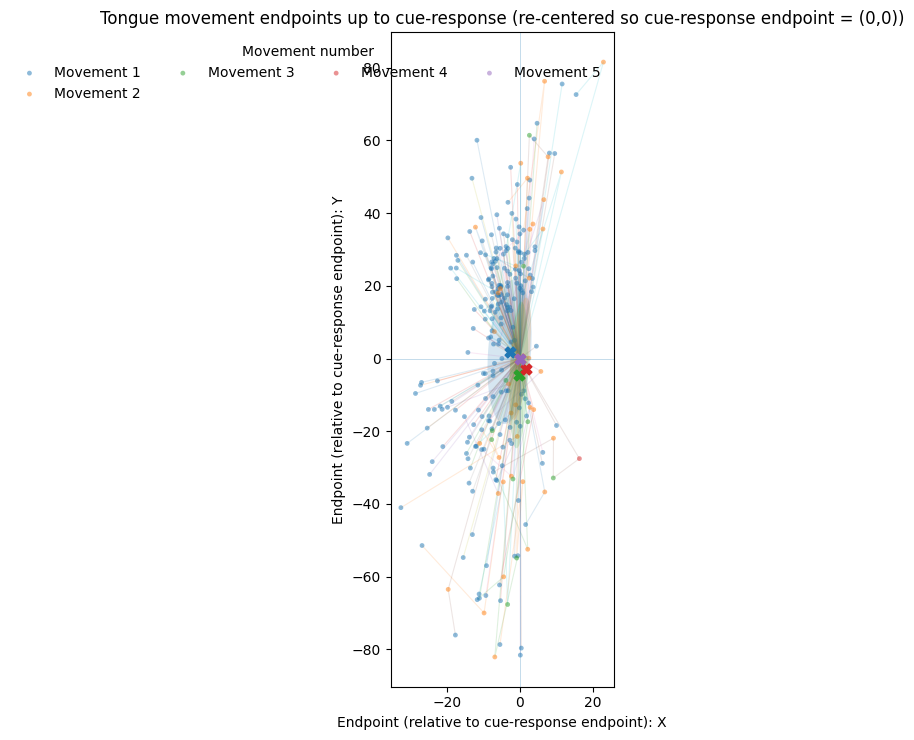

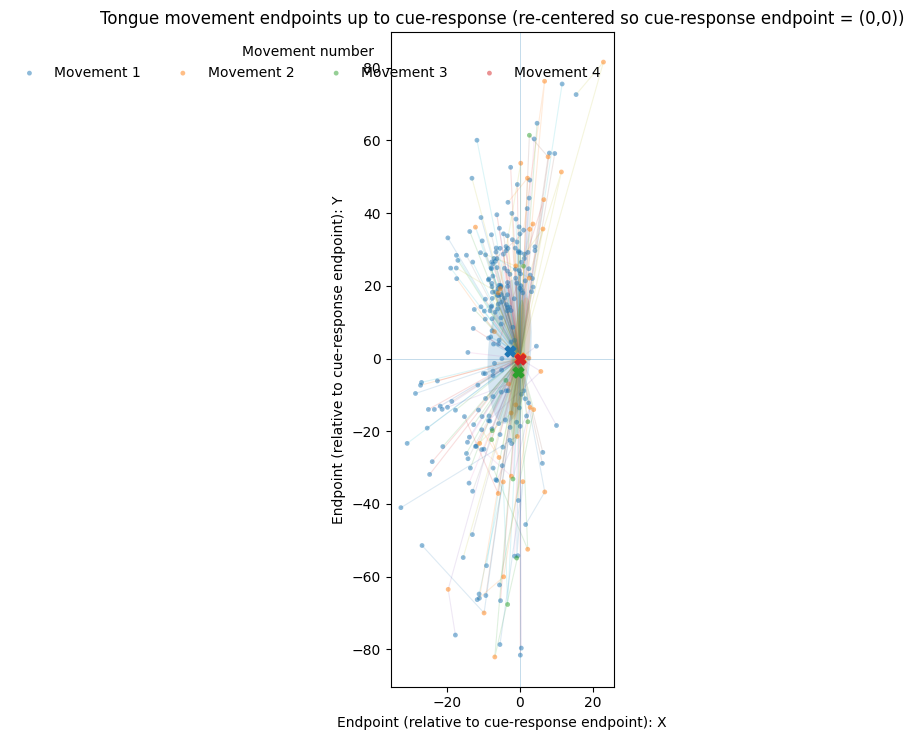

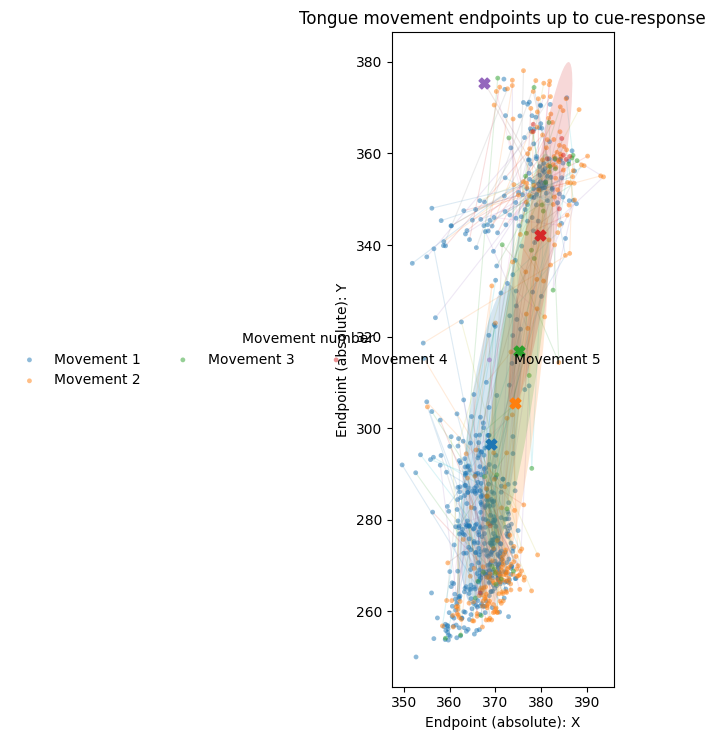

In [10]:
# assumes you've already run:
# tongue_movements = add_lick_metadata_to_movements(...); rename timestamps->lick_time
# tongue_movements = annotate_movement_timing(tongue_movements, df_trials)

# Basic: normalize to each trial’s successful endpoint (recommended)
plot_endpoints_until_cue_response(tongue_movements, normalize_to_cue=True)

# If you want to cap to the first 4 movements only:
plot_endpoints_until_cue_response(tongue_movements, normalize_to_cue=True, max_movement_to_show=4)

# If you prefer absolute coordinates (no re-centering):
plot_endpoints_until_cue_response(tongue_movements, normalize_to_cue=False)


In [11]:

def plot_endpoints_aligned_to_cue(
    tongue_movements: pd.DataFrame,
    axis='x',                 # 'x' or 'y' -> which endpoint dimension to plot
    n_pre=2,                  # show up to this many movements BEFORE cue-response (e.g., 2 -> m-2, m-1, m)
    jitter=0.08,              # horizontal jitter to avoid overplotting
    point_size=14,
    point_alpha=0.5,
    show_summary=True,        # overlay median and IQR per relative bin
    figsize=(7.5, 5.0),
):
    """
    Plot endpoint_x or endpoint_y against movement index aligned to the cue-response movement.
    X-axis: relative movement index (-n_pre ... -1, 0 where 0 = cue-response).
    Y-axis: endpoint_x or endpoint_y (absolute coordinates).

    Requires in tongue_movements:
      ['trial', 'movement_number_in_trial', 'cue_response_movement_number',
       'endpoint_x', 'endpoint_y']
    """
    if axis not in ('x', 'y'):
        raise ValueError("axis must be 'x' or 'y'")

    req = {'trial', 'movement_number_in_trial', 'cue_response_movement_number', 'endpoint_x', 'endpoint_y'}
    missing = req - set(tongue_movements.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = tongue_movements.copy()

    # Keep rows with valid movement numbers and a defined cue-response index
    df = df.dropna(subset=['trial', 'movement_number_in_trial', 'cue_response_movement_number'])
    # Cast to ints safely (nullable Int64 -> int)
    df['movement_number_in_trial'] = df['movement_number_in_trial'].astype(int)
    df['cue_response_movement_number'] = df['cue_response_movement_number'].astype(int)

    # Relative index: 0 = cue-response move; negatives = steps before
    df['rel_move'] = df['movement_number_in_trial'] - df['cue_response_movement_number']

    # Keep only the window [ -n_pre .. 0 ]
    df = df[(df['rel_move'] <= 0) & (df['rel_move'] >= -n_pre)]

    # Pick which endpoint to plot
    ycol = 'endpoint_x' if axis == 'x' else 'endpoint_y'
    df = df.dropna(subset=[ycol])

    # Optional: ensure we only use trials where we actually have the cue-response row (rel_move==0)
    # so alignment is well-defined.
    cue_trials = set(df.loc[df['rel_move'] == 0, 'trial'].unique())
    df = df[df['trial'].isin(cue_trials)]

    # Prepare figure
    fig, ax = plt.subplots(figsize=figsize)

    # discrete x positions
    rel_bins = list(range(-n_pre, 0 + 1))
    x_positions = {k: i for i, k in enumerate(rel_bins)}

    # Scatter with jitter per relative bin
    rng = np.random.default_rng(0)
    for rel in rel_bins:
        g = df[df['rel_move'] == rel]
        if g.empty:
            continue
        x0 = x_positions[rel]
        xj = x0 + rng.uniform(-jitter, jitter, size=len(g))
        ax.scatter(xj, g[ycol], s=point_size, alpha=point_alpha, edgecolor='none', label=None)

    # Summary overlays (median + IQR whiskers as vertical bars)
    if show_summary:
        for rel in rel_bins:
            g = df[df['rel_move'] == rel][ycol]
            if len(g) == 0:
                continuea
            x0 = x_positions[rel]
            q1, med, q3 = np.percentile(g, [25, 50, 75])
            # IQR "box" as a thick line; whiskers to min/max within 1.5*IQR
            iqr = q3 - q1
            low = np.min(g[g >= q1 - 1.5 * iqr]) if len(g) else q1
            high = np.max(g[g <= q3 + 1.5 * iqr]) if len(g) else q3
            # IQR bar
            ax.plot([x0, x0], [q1, q3], linewidth=6, alpha=0.5)
            # median line
            ax.plot([x0 - 0.15, x0 + 0.15], [med, med], linewidth=2)
            # whiskers
            ax.plot([x0, x0], [low, high], linewidth=1)

    # Axes/labels
    ax.set_xticks([x_positions[r] for r in rel_bins], [str(r) for r in rel_bins])
    ax.set_xlim(-0.5, len(rel_bins) - 0.5)
    ax.set_xlabel("Movement index relative to cue-response (0 = cue response)")
    ax.set_ylabel(f"Endpoint {axis.upper()} (absolute)")
    ax.set_title(f"Endpoint {axis.upper()} vs. movement index (aligned to cue-response)")

    plt.tight_layout()
    return fig, ax


(<Figure size 750x500 with 1 Axes>,
 <Axes: title={'center': 'Endpoint Y vs. movement index (aligned to cue-response)'}, xlabel='Movement index relative to cue-response (0 = cue response)', ylabel='Endpoint Y (absolute)'>)

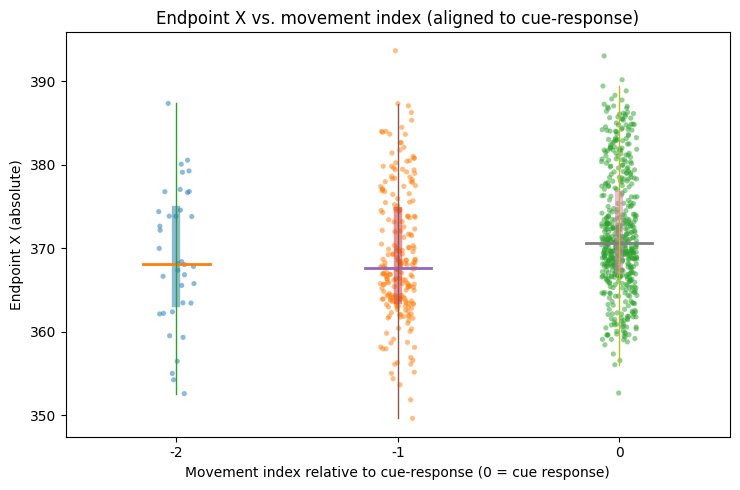

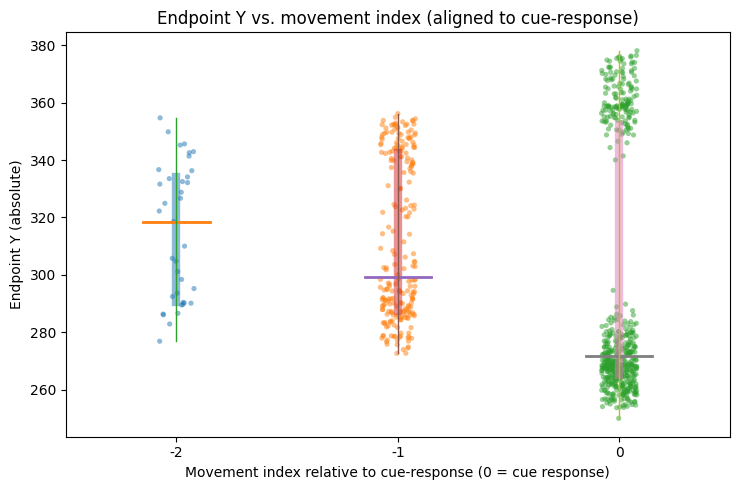

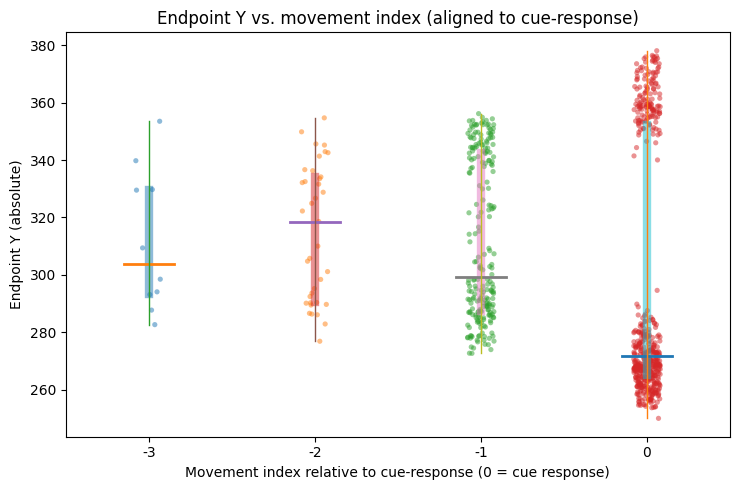

In [12]:
# After you've run annotate_movement_timing(...)
# Show X endpoints
plot_endpoints_aligned_to_cue(tongue_movements, axis='x', n_pre=2)

# Show Y endpoints
plot_endpoints_aligned_to_cue(tongue_movements, axis='y', n_pre=2)

# If you want to look back further (e.g., 3 prior movements):
plot_endpoints_aligned_to_cue(tongue_movements, axis='y', n_pre=3)


In [13]:


def plot_endpoints_aligned_to_cue(
    tongue_movements: pd.DataFrame,
    axis='x',                 # 'x' or 'y' -> which endpoint dimension to plot
    n_pre=2,                  # show up to this many movements BEFORE cue-response (e.g., 2 -> m-2, m-1, m)
    jitter=0.08,              # horizontal jitter to avoid overplotting
    point_size=14,
    point_alpha=0.5,
    line_alpha=0.15,          # transparency for connecting lines
    line_width=1.0,
    show_summary=True,        # overlay median and IQR per relative bin
    figsize=(7.5, 5.0),
):
    """
    Plot endpoint_x or endpoint_y against movement index aligned to the cue-response movement.
    X-axis: relative movement index (-n_pre ... -1, 0 where 0 = cue-response).
    Y-axis: endpoint_x or endpoint_y (absolute coordinates).

    Requires in tongue_movements:
      ['trial', 'movement_number_in_trial', 'cue_response_movement_number',
       'endpoint_x', 'endpoint_y']
    """
    if axis not in ('x', 'y'):
        raise ValueError("axis must be 'x' or 'y'")

    req = {'trial', 'movement_number_in_trial', 'cue_response_movement_number',
           'endpoint_x', 'endpoint_y'}
    missing = req - set(tongue_movements.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    df = tongue_movements.copy()

    # Keep rows with valid movement numbers and a defined cue-response index
    df = df.dropna(subset=['trial', 'movement_number_in_trial', 'cue_response_movement_number'])
    df['movement_number_in_trial'] = df['movement_number_in_trial'].astype(int)
    df['cue_response_movement_number'] = df['cue_response_movement_number'].astype(int)

    # Relative index: 0 = cue-response move; negatives = steps before
    df['rel_move'] = df['movement_number_in_trial'] - df['cue_response_movement_number']

    # Keep only the window [ -n_pre .. 0 ]
    df = df[(df['rel_move'] <= 0) & (df['rel_move'] >= -n_pre)]

    # Pick which endpoint to plot
    ycol = 'endpoint_x' if axis == 'x' else 'endpoint_y'
    df = df.dropna(subset=[ycol])

    # Keep only trials where cue-response row exists
    cue_trials = set(df.loc[df['rel_move'] == 0, 'trial'].unique())
    df = df[df['trial'].isin(cue_trials)]

    # Prepare figure
    fig, ax = plt.subplots(figsize=figsize)

    # discrete x positions
    rel_bins = list(range(-n_pre, 0 + 1))
    x_positions = {k: i for i, k in enumerate(rel_bins)}

    rng = np.random.default_rng(0)

    # Scatter with jitter + connecting lines
    for trial, g in df.groupby('trial'):
        g = g.sort_values('rel_move')
        xs = []
        ys = []
        for _, row in g.iterrows():
            rel = row['rel_move']
            if rel not in x_positions:
                continue
            x0 = x_positions[rel]
            xj = x0 + rng.uniform(-jitter, jitter)
            xs.append(xj)
            ys.append(row[ycol])
            ax.scatter(xj, row[ycol], s=point_size, alpha=point_alpha,
                       edgecolor='none', color='C0')
        if len(xs) > 1:
            ax.plot(xs, ys, '-', color='C0', alpha=line_alpha, linewidth=line_width)

    # Summary overlays (median + IQR whiskers as vertical bars)
    if show_summary:
        for rel in rel_bins:
            g = df[df['rel_move'] == rel][ycol]
            if len(g) == 0:
                continue
            x0 = x_positions[rel]
            q1, med, q3 = np.percentile(g, [25, 50, 75])
            iqr = q3 - q1
            low = np.min(g[g >= q1 - 1.5 * iqr]) if len(g) else q1
            high = np.max(g[g <= q3 + 1.5 * iqr]) if len(g) else q3
            ax.plot([x0, x0], [q1, q3], linewidth=6, alpha=0.5, color='k')
            ax.plot([x0 - 0.15, x0 + 0.15], [med, med], linewidth=2, color='k')
            ax.plot([x0, x0], [low, high], linewidth=1, color='k')

    # Axes/labels
    ax.set_xticks([x_positions[r] for r in rel_bins], [str(r) for r in rel_bins])
    ax.set_xlim(-0.5, len(rel_bins) - 0.5)
    ax.set_xlabel("Movement index relative to cue-response (0 = cue response)")
    ax.set_ylabel(f"Endpoint {axis.upper()} (absolute)")
    ax.set_title(f"Endpoint {axis.upper()} vs. movement index (aligned to cue-response)")

    plt.tight_layout()
    return fig, ax


(<Figure size 750x500 with 1 Axes>,
 <Axes: title={'center': 'Endpoint Y vs. movement index (aligned to cue-response)'}, xlabel='Movement index relative to cue-response (0 = cue response)', ylabel='Endpoint Y (absolute)'>)

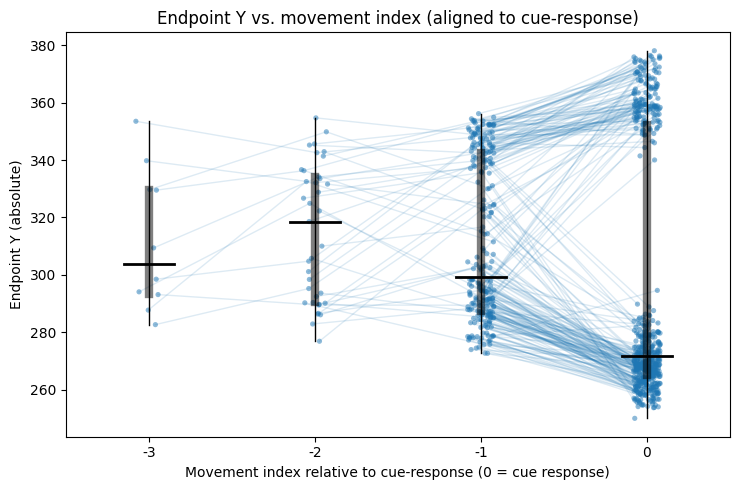

In [14]:
plot_endpoints_aligned_to_cue(tongue_movements, axis='y', n_pre=3)


In [17]:
session_folder

'/root/capsule/scratch/session_analysis_in_distribution/behavior_716325_2024-05-31_10-31-14'